In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from tqdm import tqdm

from scipy.linalg import eigh, norm, expm
from scipy.optimize import curve_fit

In [276]:
def time_evol(t,H):
    t = np.linspace(0,80,150)

    psi_in = np.array([0.]*n + [1.])
    pop = []
    phot = np.zeros((n,len(t)),dtype=np.complex128)

    for i in tqdm(np.arange(0,len(t),1)):
        temp = (expm(-1.j*H*t[i])@psi_in)
        phot[:,i] = temp[:-1]
        pop.append(temp[-1])
    
    return pop, phot

In [2]:
def JC_atom(t,g,det):
    
    om = np.sqrt(det**2 + 4.*(g**2))
    
    return 1. - (4*(g**2)/(om**2))*np.sin(t*om/2)**2

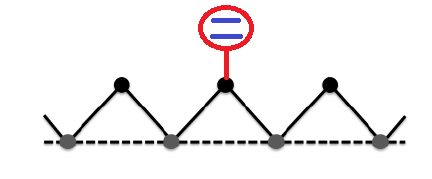

In [3]:
from IPython import display
display.Image("sawtooth_em.png")

In this notebook we study the coupling of several quantum emitters to the sawtooth lattice in different energetic and topological configurations.

# A quantum emitter coupled to the sawtooth lattice

We set the optimal parameters to get a flat band.

In [4]:
N = 200 #number of primitive cells
n = 2*N #number of points

eps_a = eps_b = 0.

t_aa = 0.
t_ab = np.sqrt(2)
t_bb = 1.

## Coupling to an A site

We couple the atom to an A site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ a_n + \sigma^- a_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $a_n$ is the annihilation operator of a field excitation in the n-th A-site. 

We choose here the transition frequency of the atom ($\omega_0$) and the coupling strenght $g$.

In [259]:
omega0 = -2 #atom frequency
g = 0.1 #atom-cavity coupling

In [260]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
H += np.diag([-t_ab]*(n-1) + [0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

H[0,n-2] -= t_bb
H[N-1,-1] -= g #coupling to an A site in the middle

H += np.conjugate(H.transpose())

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [ ]:
t = np.linspace(0,80,150)
pop, phot = time_evol(t,H)

We plot here the time evolution of the atomic part of the wavefunction.

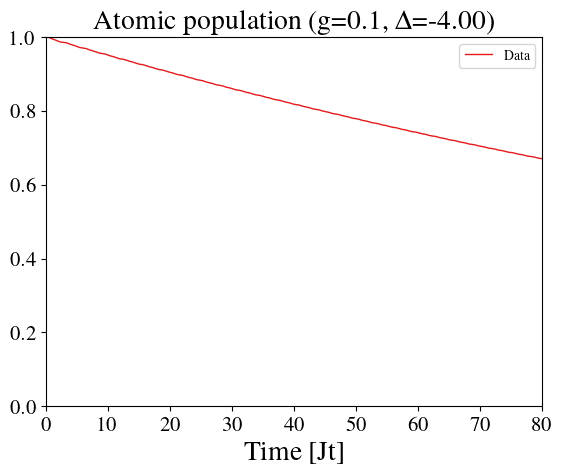

In [262]:
fig = plt.figure()

fac = 1.9498285473526304
pop_at = np.real(pop*np.conjugate(pop))
plt.plot(t,pop_at,c='#e41a1c',lw=1,label="Data")
#plt.plot(t,JC_atom(t,fac*g/3,omega0-2),ls="--",label="Fit",c='#dede00')

plt.title(f"Atomic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("Time [Jt]",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()

plt.savefig(f"plots/Asite/at_A_{omega0*100:.0f}.png")
plt.show()

In [263]:
np.where(pop_at == min(pop_at[:150]))

(array([149], dtype=int64),)

In [264]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [269]:
vec = [50,70,11]

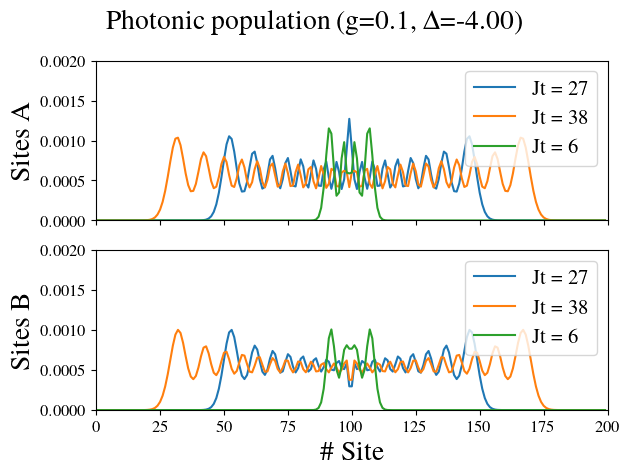

In [271]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=True)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}")
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}")


plt.suptitle(f"Photonic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

plt.xlim(0,200)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)
ax[0].set_ylim(0,2e-3)
ax[1].set_ylim(0,2e-3)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)

plt.savefig(f"plots/Asite/phot_A_{omega0*100:.0f}.png")

plt.show()

In [ ]:
fig = plt.figure()

for s in vec:
    plt.plot(pop_phot[:,s],label=f"Jt = {t[s]:.0f}")

#vec = np.arange(199,400,1)
#plt.plot(vec,0.418*np.exp(1.15*(199-vec)))
plt.title(f"Photonic population (g={g:.1f}, $\Delta$={omega0-2.:.2f}))",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

plt.xlim(100,300)
plt.ylim(5e-5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)

#plt.savefig(f"plots/phot_A_log_{omega0*100:.0f}.png")

plt.show()

# Coupling to a B site

We couple the atom to a B site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ b_n + \sigma^- b_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $b_n$ is the annihilation operator of a field excitation in the n-th B-site. 

In [514]:
omega0 = 0.3#atom frequency
g = 0.1 #atom-cavity coupling

In [515]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
H += np.diag([-t_ab]*(n-1) + [0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

H[0,n-2] -= t_bb
H[N-2,-1] -= g #coupling to a B site in the middle

H += np.conjugate(H.transpose())

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [516]:
t = np.linspace(0,80,150)
pop, phot = time_evol(t,H)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.25it/s]


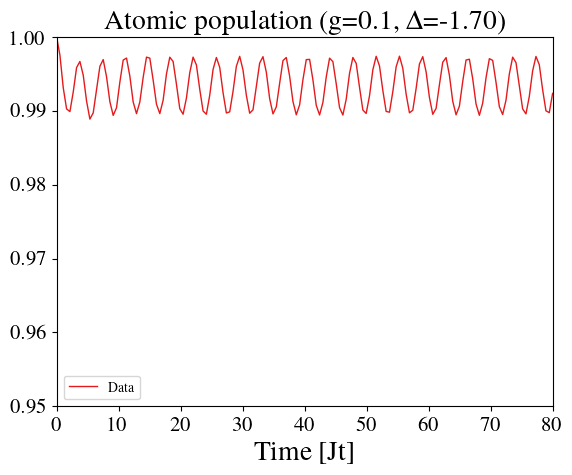

In [517]:
fig = plt.figure()

fac = 2.3
pop_at = np.real(pop*np.conjugate(pop))
plt.plot(t,pop_at,c='#e41a1c',lw=1,label="Data")
#plt.plot(t,JC_atom(t,fac*g/3,omega0-2),ls="--",label="Fit",c='#dede00')

plt.title(f"Atomic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("Time [Jt]",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.95,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()

plt.savefig(f"plots/Bsite/at_B_{omega0*100:.0f}.png")
plt.show()

In [494]:
np.where(pop_at == min(pop_at[:20]))

(array([4], dtype=int64),)

In [509]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [510]:
vec = [6,25,50]

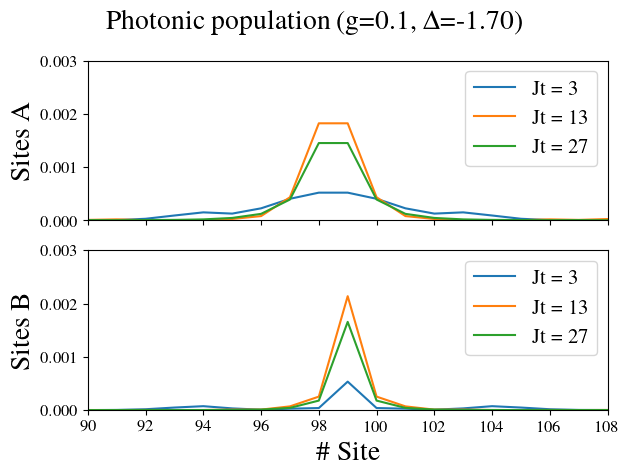

In [513]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=True)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}")
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}")


plt.suptitle(f"Photonic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

plt.xlim(90,108)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)
ax[0].set_ylim(0,3e-3)
ax[1].set_ylim(0,3e-3)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)

plt.savefig(f"plots/Bsite/phot_B_{omega0*100:.0f}.png")

plt.show()